In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing the dataset

[Google Local Data (2021). Alaska 10-core (521,515 reviews)](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

This Dataset contains review information on Google map (ratings, text, images, etc.), business metadata (address, geographical info, descriptions, category information, price, open hours, and MISC info), and links (relative businesses) up to Sep 2021 in the United States.

These data have been reduced to extract the k-core, such that each of the remaining users and items have k reviews each.

<ul>
<li>user_id - ID of the reviewer
<li>name - name of the reviwer
<li>time - time of the review (unix time)
<li>rating - rating of the business
<li>text - text of the review
<li>pics - pictures of the review
<li>resp - business response to the review including unix time and text of the response
<li>gmap_id - ID of the business
</ul>

Metadata:
<ul>
<li>name - name of the business
<li>address - address of the business
<li>gmap_id - ID of the business
<li>description - description of the business
<li>latitude - latitude of the business
<li>longitude - longitude of the business
<li>category - category of the business
<li>avg_rating - average rating of the business
<li>num_of_reviews - number of reviews
<li>price - price of the business
<li>hours - open hours
<li>MISC - MISC information
<li>state - the current status of the business (e.g., permanently closed)
<li>relative_results - relative businesses recommended by Google
<li>url - URL of the business
</ul>

Format is one-review-per-line in json.

Citation
1. UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining
Jiacheng Li, Jingbo Shang, Julian McAuley
Annual Meeting of the Association for Computational Linguistics (ACL), 2022
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)

2. Personalized Showcases: Generating Multi-Modal Explanations for Recommendations
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley
The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR), 2023
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

In [157]:
df_reviews = pd.read_json('./data/review-Alaska_10.json.gz', lines=True, compression='gzip')

In [158]:
df_reviews.head(3)

,user_id,name,time,rating,text,pics,resp,gmap_id
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952


In [199]:
df_meta = pd.read_json('./data/meta-Alaska.json.gz', lines=True, compression='gzip')

In [200]:
df_meta.head(3)

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Bear Creek Cabins & RV Park,"Bear Creek Cabins & RV Park, 3181 Richardson H...",0x56b646ed2220b77f:0xd8975e316de80952,None,61.100644,-146.214552,"[RV park, Cabin rental agency, Campground]",4.5,18,None,None,None,None,"[0x56b6445fd9f9e387:0x6dd3d374ef56431a, 0x56b6...",https://www.google.com/maps/place//data=!4m2!3...
1,Anchorage Market,"Anchorage Market, 88th Ave, Anchorage, AK 99515",0x56c8992b5dee7225:0x9f7f4bf151868cf7,None,61.141435,-149.868482,[Farmers' market],4.2,18,None,"[[Thursday, Closed], [Friday, 10AM–5PM], [Satu...","{'Service options': ['In-store shopping'], 'Ac...",Closed ⋅ Opens 10AM Fri,None,https://www.google.com/maps/place//data=!4m2!3...
2,Happy Camper RV,"Happy Camper RV, 1151 N Shenandoah Dr # 4, Pal...",0x56c8e0455225be87:0xf24828df75e2f8ae,None,61.591855,-149.290657,[RV repair shop],4.4,28,None,None,{'Accessibility': ['Wheelchair accessible entr...,None,"[0x56c8e104d9929a1d:0x2070ad63defadbf, 0x56c91...",https://www.google.com/maps/place//data=!4m2!3...


In [161]:
df_meta['category'].value_counts()[:20]

category
[Lake]                        167
[Restaurant]                  163
[River]                       162
[Coffee shop]                 150
[Gas station]                 139
[Campground]                  109
[Cafe]                        106
[Bar]                          94
[Hiking area]                  91
[Hotel]                        87
[Park]                         83
[Grocery store]                81
[Cannabis store]               78
[Tourist attraction]           76
[Gift shop]                    76
[Park, Tourist attraction]     70
[Church]                       69
[Bay]                          65
[Auto repair shop]             62
[Non-profit organization]      61
Name: count, dtype: int64

## Preprocessing

### Removing unnecessary features

In [162]:
# We'll be using only gmap_id, address, avg_rating, num_of_reviews and MISC as business features
feature_columns = ['gmap_id', 'address', 'category', 'avg_rating', 'num_of_reviews', 'MISC']
df_meta = df_meta.loc[:, feature_columns]

In [163]:
# We need only user_id, rating and gmap_id
feature_columns = ['user_id', 'gmap_id', 'rating']
df_reviews = df_reviews[feature_columns]

### Count of businesses by city

In [164]:
def get_city(address):
    if not address:
        return None
    
    address_fields = address.split(', ')

    if len(address_fields) == 1:
        return address_fields[0]
    
    return address_fields[-2]

df_meta['address'].apply(lambda address: get_city(address)).value_counts()[:10]

address
Anchorage      4228
Fairbanks      1285
Wasilla         863
Juneau          642
Palmer          428
Soldotna        344
Ketchikan       323
Homer           307
Eagle River     270
Kenai           240
Name: count, dtype: int64

### Filters

In [165]:
# City we want to analize
city = 'Fairbanks'

# Minimum number of reviews for business and
# munimum number of reviews by user for these businesses to make recommendations
reviews_threshold = 10
min_user_reviews_for_business = 5

### Get businesses

In [166]:
def is_address_from_city(address, city):
    if not address:
        return False
    
    address_fields = address.split(', ')

    if len(address_fields) == 1:
        return address_fields[0] == city
    
    if address_fields[-2] == city:
        return True
    return False

city_mask = df_meta['address'].apply(lambda address: is_address_from_city(address, city))
popularity_mask = df_meta['num_of_reviews'] >= reviews_threshold

businesses_from_city = df_meta[city_mask & popularity_mask].reset_index(drop=True)
print(f'{len(businesses_from_city)=}')

len(businesses_from_city)=897


### Get users

In [167]:
def user_is_good_for_city(user_id, reviews_threshold):
    global businesses_from_city, df_reviews

    user_reviews = df_reviews[df_reviews['user_id'] == user_id]
    reviews_count = user_reviews['gmap_id'].isin(businesses_from_city['gmap_id']).sum()

    return reviews_count >= reviews_threshold

user_ids = pd.Series(df_reviews['user_id'].unique())
user_mask = user_ids.apply(lambda user_id: user_is_good_for_city(user_id, reviews_threshold))

users_from_city = user_ids[user_mask].reset_index(drop=True)

### Delete redundant reviews, final filter of bussinesses

In [168]:
# Delete redundant reviews
business_mask = df_reviews['gmap_id'].isin(businesses_from_city['gmap_id'])
user_mask = df_reviews['user_id'].isin(users_from_city)

df_reviews = df_reviews[business_mask & user_mask]

# Filter businesses by min_user_reviews_for_business
popularity_mask = businesses_from_city['gmap_id'].apply(lambda x:
    (df_reviews['gmap_id'] == x).sum() >= min_user_reviews_for_business
)
businesses_from_city = businesses_from_city[popularity_mask].reset_index(drop=True)

# Delete redundant reviews after final business filtering
business_mask = df_reviews['gmap_id'].isin(businesses_from_city['gmap_id'])
df_reviews = df_reviews[business_mask]

### One-hot encoding for category feature

In [169]:
categories = []
for business_categories in businesses_from_city['category'].to_list():
    categories.extend([category for category in business_categories])

categories = list(set(categories))
categories_indices = {category: i for i, category in enumerate(categories)}
categories_count = len(categories)

categories_count

663

In [170]:
def get_one_hot_categories(business_categories):
    global categories_indices

    one_hot_encoding = np.zeros(categories_count)

    for category in business_categories:
        one_hot_encoding[categories_indices[category]] = 1

    return one_hot_encoding

one_hot_categories = np.array(businesses_from_city['category'].apply(get_one_hot_categories).to_list())
one_hot_categories.shape

(742, 663)

In [171]:
# Check if one-hot encoding works correctly
for categories, count_of_categories in zip(
    businesses_from_city['category'].to_list()[:4],
    one_hot_categories.sum(axis=1).reshape(-1, 1)[:4]):

    print('categories:')
    for category in categories:
        print(f' - {category}')
    print(f'count: {int(count_of_categories)}\n')

categories:
 - Dentist
count: 1

categories:
 - Car repair and maintenance
 - Auto repair shop
 - Diesel engine repair service
 - Engine rebuilding service
 - Transmission shop
 - Truck repair shop
count: 6

categories:
 - Mover
 - Moving and storage service
 - Moving supply store
count: 3

categories:
 - Bingo hall
count: 1



### One-hot encoding for MISC feature

In [ ]:
misc_types, options = {}, {}
misc_types_count = options_count = 0

for misc in df_meta[df_meta['MISC'].values != None]['MISC']:
    misc_types_list, options_list = list(misc.keys()), list(misc.values())

    # Flatten the options list
    options_list = [option for options in options_list for option in options]

    for misc_type in misc_types_list:
        misc_types[misc_type] = misc_types.get(misc_type, 0) + 1

    for option in options_list:
        options[option] = options.get(option, 0) + 1
        
    misc_types_count += len(misc_types_list)
    options_count += len(options_list)

In [ ]:
len(misc_types), len(options), misc_types_count, options_count

(18, 171, 32073, 62158)

In [ ]:
options_occurencies = pd.DataFrame(np.c_[list(options.items())], columns=['Option', 'Occurrencies'])
options_occurencies['Occurrencies'] = options_occurencies['Occurrencies'].astype(int)
options_occurencies.sort_values(by='Occurrencies', ascending=False)

,Option,Occurrencies
1,Wheelchair accessible entrance,7375
6,Delivery,3313
10,Good for kids,2388
0,In-store shopping,1973
4,Takeout,1738
...,...,...
86,Assistive hearing loop,1
121,All-inclusive,1
112,Counter service,1
103,Language assistance,1


In [ ]:
misc_types_occurencies = pd.DataFrame(np.c_[list(misc_types.items())], columns=['MISC type', 'Occurrencies'])
misc_types_occurencies['Occurrencies'] = misc_types_occurencies['Occurrencies'].astype(int)
misc_types_occurencies.sort_values(by='Occurrencies', ascending=False)

,MISC type,Occurrencies
1,Accessibility,7512
0,Service options,4398
2,Amenities,3302
3,Planning,2952
7,Offerings,2431
8,Payments,1983
12,Health & safety,1646
6,Atmosphere,1625
9,Crowd,1577
10,Highlights,1528


## Data summary

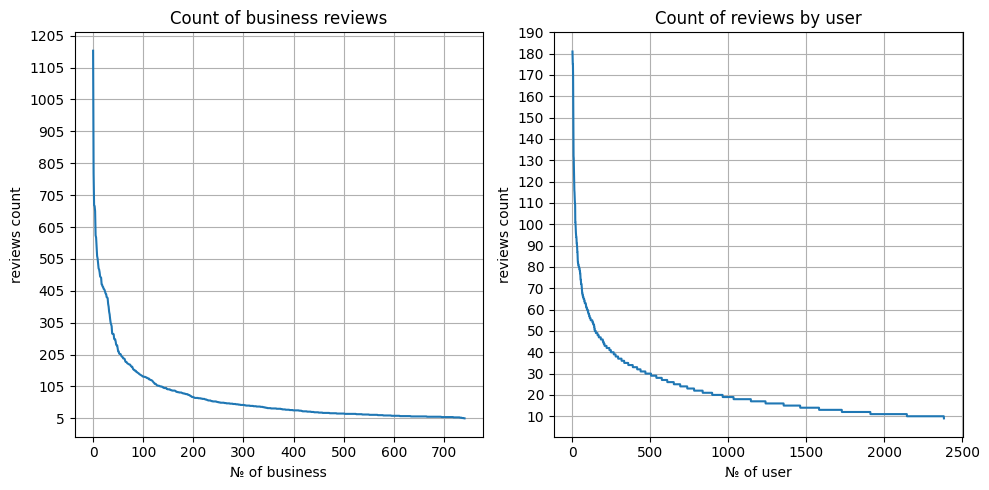

In [172]:
count_of_business_reviews = df_reviews.groupby('gmap_id').count()['user_id']\
    .sort_values(ascending=False).values

count_of_reviews_by_user = df_reviews.groupby('user_id').count()['gmap_id']\
    .sort_values(ascending=False).values

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Count of business reviews')
plt.plot(count_of_business_reviews)
plt.ylabel('reviews count')
plt.xlabel('№ of business')
plt.yticks(np.arange(min_user_reviews_for_business, count_of_business_reviews[0]+100, 100))
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Count of reviews by user')
plt.plot(count_of_reviews_by_user)
plt.ylabel('reviews count')
plt.xlabel('№ of user')
plt.yticks(np.arange(reviews_threshold, count_of_reviews_by_user[0]+10, 10))
plt.grid()

plt.tight_layout()

In [173]:
users_from_city_count = len(users_from_city)
businesses_from_city_count = len(businesses_from_city)
reviews_count = len(df_reviews)

print(f'Count of users: {users_from_city_count}\n'
      f'Count of businesses: {businesses_from_city_count}\n'
      f'Count of reviews: {reviews_count}')

Count of users: 2382
Count of businesses: 742
Count of reviews: 54442


In [174]:
businesses_from_city['category'].apply(lambda x: x[0] if x else None).value_counts()

category
Restaurant              19
Coffee shop             18
Gas station             17
American restaurant     16
Cafe                    14
                        ..
Trailer supply store     1
Car stereo store         1
Playground               1
Shooting range           1
Resort hotel             1
Name: count, Length: 315, dtype: int64

## Preparing the data for heterogeneous graph representation

In [175]:
import torch
import torch_geometric.nn as gnn
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [177]:
user_id_to_idx = {user_id: idx for idx, user_id in users_from_city.items()}
gmap_id_to_idx = {gmap_id: idx for idx, gmap_id in businesses_from_city['gmap_id'].items()}

edges = np.vstack([
    df_reviews['user_id'].map(user_id_to_idx).values,
    df_reviews['gmap_id'].map(gmap_id_to_idx).values
])

ratings = df_reviews['rating'].values

In [178]:
data = HeteroData()

# Add user node features for message passing
data['user'].x = torch.eye(users_from_city_count)
# Add business node features
data['business'].x = torch.Tensor(
    np.c_[businesses_from_city[['avg_rating', 'num_of_reviews']].values, one_hot_categories]
)

# Add edges (users ratings for businesses)
data['user', 'rates', 'business'].edge_index = torch.tensor(edges)
# Add rating to edges
data['user', 'rates', 'business'].edge_label = torch.tensor(ratings)

# Add a reverse ('business', 'rev_rates', 'user') relation for message passing
data = T.ToUndirected()(data)
# Remove reverse label.
del data['business', 'rev_rates', 'user'].edge_label

data.to(device)

data

HeteroData(
  user={ x=[2382, 2382] },
  business={ x=[742, 665] },
  (user, rates, business)={
    edge_index=[2, 54442],
    edge_label=[54442],
  },
  (business, rev_rates, user)={ edge_index=[2, 54442] }
)

### Graph visualization

In [179]:
import winsound
import networkx as nx
from torch_geometric.utils import to_networkx

In [180]:
# G = to_networkx(data.to, to_undirected=False)
# plt.figure(figsize=(20, 20))

# node_type_map = {'user': 0, 'business': 1}
# color_values = [node_type_map[node['type']] for node in G.nodes().values()]

# nx.draw_networkx(
#     G,
#     pos=nx.layout spring_layout(G, seed=2010),
#     node_size=3,
#     node_color=color_values,
#     edge_color='grey',
#     with_labels=False
# )

# winsound.Beep(frequency = 1500, duration = 500)

## Model training

In [186]:
torch.bincount(train_data['user', 'business'].edge_label)

tensor([    0,  1691,  1626,  5319, 11136, 23782], device='cuda:0')

Epoch: 001, Loss: 117.3099, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 002, Loss: 112.0636, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 003, Loss: 107.0549, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 004, Loss: 102.2875, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 005, Loss: 97.7540, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 006, Loss: 93.4387, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 007, Loss: 89.3275, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 008, Loss: 85.4117, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 009, Loss: 81.6870, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 010, Loss: 78.1418, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 011, Loss: 74.7693, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 012, Loss: 71.5686, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 013, Loss: 68.5374, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 014, Loss: 65.6749, Train: 4.3591, Val: 4.3836, Test: 4.3735
Epoch: 015, Loss: 62.9733, Train: 4.3591, Va

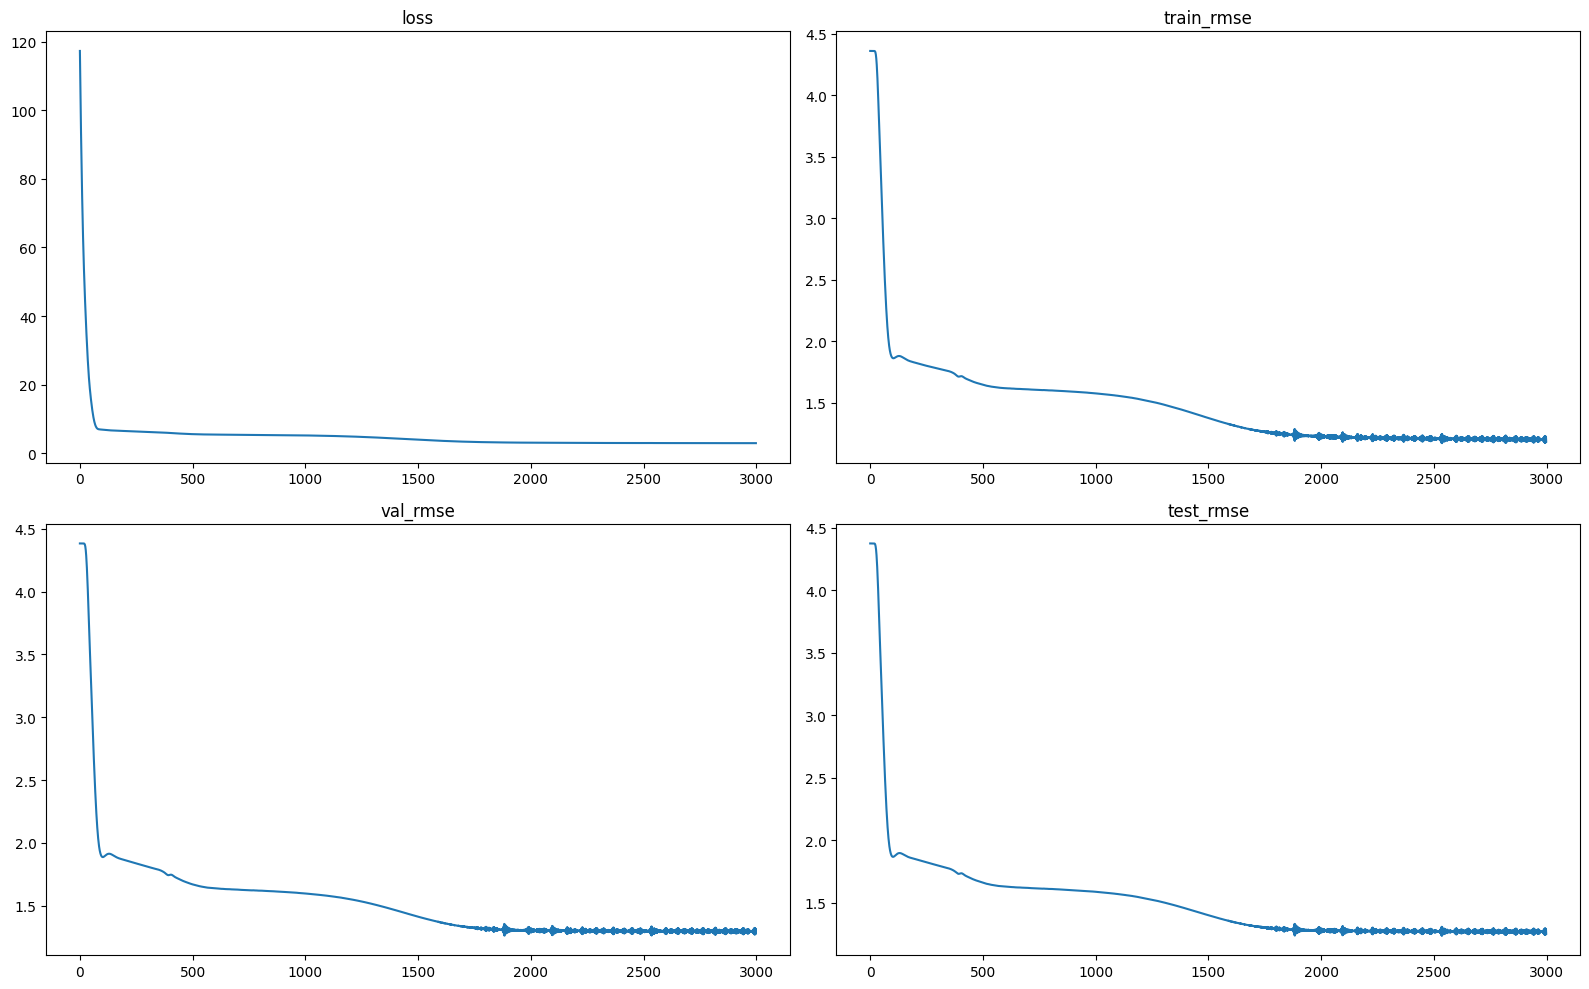

In [197]:
# Perform a link-level split into training, validation, and test edges
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'business')],
    rev_edge_types=[('business', 'rev_rates', 'user')],
)(data)

# We have an unbalanced dataset of ratings, therefore we use a weighted MSE loss.
weight = torch.bincount(train_data['user', 'business'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = gnn.SAGEConv((-1, -1), hidden_channels)
        self.conv2 = gnn.SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['business'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = gnn.to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

model = Model(hidden_channels=10).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'business'].edge_label_index)
    target = train_data['user', 'business'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'business'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'business'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

losses, train_rmses, val_rmses, test_rmses = [], [], [], []

for epoch in range(1, 3000):
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    
    losses.append(loss)
    train_rmses.append(train_rmse), val_rmses.append(val_rmse), test_rmses.append(test_rmse)

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.title('loss')
plt.plot(losses)

plt.subplot(2, 2, 2)
plt.title('train_rmse')
plt.plot(train_rmses)

plt.subplot(2, 2, 3)
plt.title('val_rmse')
plt.plot(val_rmses)

plt.subplot(2, 2, 4)
plt.title('test_rmse')
plt.plot(test_rmses)

plt.tight_layout()